In [133]:
import pandas as pd
import geopandas as gpd
import contextily as cx
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import japanize_matplotlib
from os.path import join
from settings import geodatadir
import itertools
import sklearn.metrics as metrics
import scipy.stats as stats
from shapely.geometry import Point, LineString, MultiLineString
# 地図は背景に地理院地図（国土地理院）を使用している場合があります。

In [2]:
mesh = gpd.read_file('data/syutoken_mesh.geojson')

In [3]:
mesh_codes = list(itertools.chain.from_iterable(
    [(np.array([5238, 5239, 5240]) + xx) for xx in [0, 100, 200, 300]]))

In [4]:
# 経済センサスメッシュデータの準備
keizai = pd.concat([pd.read_csv(join(geodatadir, f"keizai500/tblT000389H{x}.txt"), encoding='sjis', skiprows=1) for x in mesh_codes])
keizai.columns = ['KEY_CODE', 'company', 'people']
keizai.KEY_CODE = keizai.KEY_CODE.astype(str)
keizai = pd.merge(mesh, keizai, on='KEY_CODE')

In [5]:
# 公示地価データの準備
chika = pd.concat([gpd.read_file(geodatadir + f'../chika/L01-22_{x:02}.geojson', crs=4612).to_crs(2451)
    for x in range(8, 15)])
chika = chika[(chika.L01_027 == '住宅') & (chika.L01_049 > 700) & (chika.L01_049 < 1300)]
chika = chika[['L01_006', 'L01_026', 'L01_049', 'geometry']]
chika.columns = ['price', 'menseki', 'station', 'geometry']
chika['no'] = chika.index
chika['p10'] = np.log10(chika.price)
chika['tokyo'] = chika.geometry.distance(keizai.sort_values('people', ascending=False).geometry.values[0])

In [161]:
stations = gpd.read_file(geodatadir + 'stations.geojson', crs=4612).to_crs(2451)

In [100]:
def append_keizai_keizai():
    res = []
    k5000 = keizai[keizai.people >= 5000]
    for p, g in zip(keizai.people, keizai.geometry):
        if p < 5000:
            res.append(0)
            continue
        x = []
        for gg, p in zip(k5000.geometry.centroid, k5000.people):
            x.append(p / ((gg.distance(g) ** 2.5) + 250))
        res.append(sum(x))
    return res
keizai['keizai'] = append_keizai_keizai()
x = keizai.drop('geometry', 1)

c:\Users\nazo\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


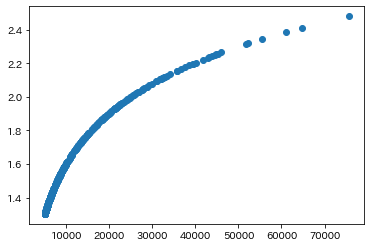

In [101]:
plt.scatter(keizai.people, np.log10(keizai.keizai))

In [117]:
def calc_keizai_dist(geom, kahen=True):
    x = keizai[keizai.people >= 5000]
    xx = []
    for g, p, k in zip(x.geometry.centroid, x.people, x.keizai):
        e = np.log10(k) if kahen else 1.5
        xx.append((p / ((geom.distance(g) ** e) + 250)))
    return sum(xx)

In [123]:
chikap = chika.copy()

In [124]:
# 従業者数が多いメッシュからの距離を加重平均して変数とする
chikap['keizai'] = np.log10([calc_keizai_dist(x) for x in chikap.geometry])
chikap['keizai_old'] = np.log10([calc_keizai_dist(x, False) for x in chikap.geometry])

In [170]:
chikap['tokyo_dist'] = chikap.geometry.distance(stations[stations.N02_005 == '東京'].geometry.values[0])

In [127]:
# 予測モデル作成
def chika_yosoku(p, x, y):
    a, b = np.polyfit(p[x], p[y], 1)
    r2 = metrics.r2_score(p[y], a * p[x] + b)
    zansa = p[y] - (p[x] * a + b)
    return round(a, 5), round(b, 5), r2, zansa

1.0598 5.10619 0.8166440144313398


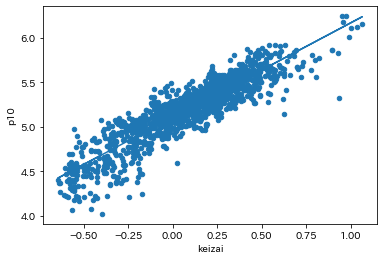

In [174]:
x = stations[stations.N02_005 == '東京'].geometry.values[0]
p = chikap[chikap.geometry.distance(x) < 80000].copy()
x = chika_yosoku(p, 'keizai', 'p10')
p['a'], p['b'], p['zansa'] = x[0], x[1], x[3]
p.to_file('ignore/t1')
print(x[0], x[1], x[2])
ax = p.plot(x='keizai', y='p10', kind='scatter')
ax.plot(p.keizai, x[0] * p.keizai + x[1])
plt.show()

0.91007 5.03137 0.7909901229296338


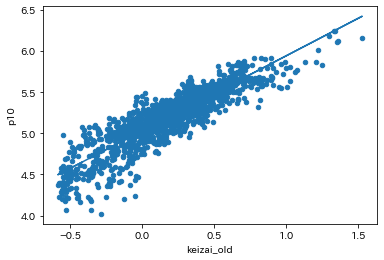

In [173]:
x = stations[stations.N02_005 == '東京'].geometry.values[0]
p = chikap[chikap.geometry.distance(x) < 80000].copy()
x = chika_yosoku(p, 'keizai_old', 'p10')
print(x[0], x[1], x[2])
p['zansa'] = x[3]
p.to_file('ignore/t2')

ax = p.plot(x='keizai_old', y='p10', kind='scatter')
ax.plot(p.keizai_old, x[0] * p.keizai_old + x[1])
plt.show()

-2e-05 5.73558 0.6073711601696175


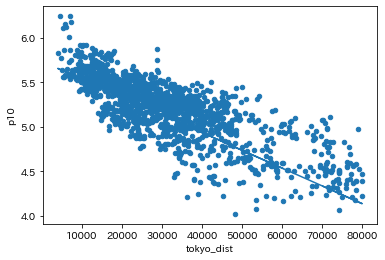

In [172]:
x = stations[stations.N02_005 == '東京'].geometry.values[0]
p = chikap[chikap.geometry.distance(x) < 80000].copy()
x = chika_yosoku(p, 'tokyo_dist', 'p10')
print(x[0], x[1], x[2])
p['zansa'] = x[3]
p.to_file('ignore/t3')

ax = p.plot(x='tokyo_dist', y='p10', kind='scatter')
ax.plot(p.tokyo_dist, x[0] * p.tokyo_dist + x[1])
plt.show()

In [182]:
# 京王線の駅の住宅地価を予測してみる
pred_railway = stations[stations.N02_003 == "横浜線"].iloc[:, 4:].copy()
pred_railway.columns = ['station', 'geometry']
x = stations[stations.N02_005 == '東京'].geometry.values[0]
pred_railway['tokyo'] = pred_railway.geometry.distance(x)
pred_railway['keizai'] = np.log10([calc_keizai_dist(x) for x in pred_railway.geometry])
pred_railway['pred'] = (10 ** (p.a.values[0] * pred_railway.keizai + p.b.values[0]) * 3.30579) / 10000
x = pred_railway.drop('geometry', 1)
x

,station,tokyo,keizai,pred
6615,新横浜,23418.269400,1.021320,510.340649
6616,東神奈川,25339.161155,0.410208,114.869265
6617,小机,24277.493035,0.306041,89.085708
6618,大口,23432.719182,0.405973,113.688158
6619,菊名,22518.206648,0.451677,127.102099
6620,橋本,39317.068751,-0.021991,40.009185
6621,中山,27565.879951,0.185767,66.426486
6622,成瀬,31067.612829,0.116559,56.104127
6623,相模原,37477.797933,0.008465,43.095910
6624,町田,32797.528996,0.358367,101.219248
